# Retrieve HYCOM grid and mask with land
- velocities are interpolated at the center of the cell (`plon`, `plat`)
- get corners of cell for binning and plotting (`qlon`, `qlat`)

In [1]:
import xarray as xr
import numpy as np
from scipy.ndimage import generic_filter
from datetime import datetime
from os.path import join
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/nexsan/people/pmiron/projects_mars/HYCOM-utilities/python/')
import hycom.io as hio

In [3]:
file = '../data/raw/hycom/regional.grid.glbv'
r = hio.read_hycom_coords(file, ['qlon', 'qlat', 'plon', 'plat'])
qlon, qlat, plon, plat = r['qlon'][0], r['qlat'][:,0], r['plon'][0], r['plat'][:,0]

In [4]:
# read first velocity fields to get pgrid
ds = xr.open_dataset('../data/raw/hycom/hycom_GLBv0.08_536_2010010112_t000.nc')

# land is nan
land = np.zeros_like(ds.surf_u[0], dtype='bool')
land[np.isnan(ds.surf_v[0].values)] = 1

assert(np.allclose(plon, ds.longitude.values, atol=1e-4))
assert(np.allclose(plat, ds.latitude.values))

ds.close()

In [5]:
# slice inside caribbean region
i0 = 1012; i1 = 1650
j0 = 1500; j1 = 1894

lon_slice = slice(i0, i1)
lat_slice = slice(j0, j1)
land = land[lat_slice, lon_slice]
plon = plon[lon_slice]
plat = plat[lat_slice]

qlon = qlon[slice(i0, i1+1)]
qlat = qlat[slice(j0, j1+1)]

In [6]:
for v in [plon, qlon, plat, qlat]:
    print(v[:3])

[-99.04000092 -98.95999908 -98.87999725]
[-99.08000183 -99.         -98.91999817]
[0.   0.08 0.16]
[-0.04  0.04  0.12]


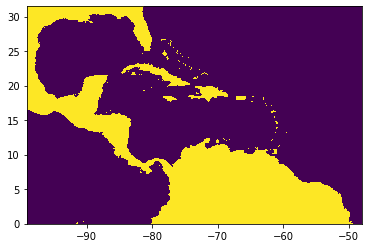

In [7]:
plt.pcolormesh(qlon, qlat, land)

In [8]:
# to increase the size of the land we can use this type of filter
# size 2 means the bin itself and 1 bin around
# size 3 means the bin itself and two bins around
land_1x = generic_filter(land, lambda x: np.max(x), size=2, mode='constant')
land_2x = generic_filter(land, lambda x: np.max(x), size=3, mode='constant')

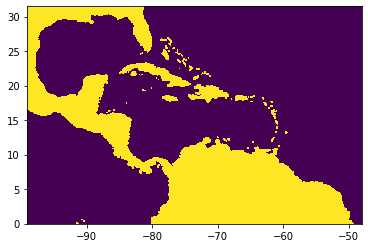

In [9]:
plt.pcolormesh(qlon, qlat, land_2x)

In [10]:
# save to netCDF
xr.Dataset(
    data_vars=dict(
        land=(['lat', 'lon'], land, {'long_name': 'land mask for GLBv0.08', 'units':'-', 'flag_values':'True, False', 'flag_meanings': 'land, ocean'}),
    ),

    coords=dict(
        plon=(['lon'], plon, {'long_name': 'longitude center cell', 'units':'degrees_east'}),
        plat=(['lat'], plat, {'long_name': 'latitude center cell', 'units':'degrees_north'}),
        qlon=(['lon1'], qlon, {'long_name': 'longitude q', 'units':'degrees_east'}),
        qlat=(['lat1'], qlat, {'long_name': 'latitude q', 'units':'degrees_north'}),
    ),

    attrs={
        'title': 'HYCOM GLBv0.08 land mask',
        'institution': 'Florida State University Center for Ocean-Atmospheric Prediction Studies (COAPS)',
        'date_created': datetime.now().isoformat(),
    }
).to_netcdf(join('../data/process', 'land_GLBv0.08.nc'))